<a href="https://colab.research.google.com/github/Beagan19/food-sales-predictions/blob/main/food_sales_predictions_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data


In [1]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config
set_config(display='diagram')

In [3]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),6)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),6)

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [4]:
food_sales_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/sales_predictions.xlsx')
food_sales_df.info()
food_sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   float64
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(5), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998.0,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052


## Data Cleaming

In [5]:
# duplicate rows
duplicate = food_sales_df.duplicated()
duplicate.sum()

0

In [6]:
food_sales_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
# check for number of unique values in each column
food_sales_df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [8]:
# find and fix inconsistent categories
food_sales_df["Item_Fat_Content"].value_counts()
food_sales_df["Item_Fat_Content"] = food_sales_df["Item_Fat_Content"].replace('LF', 'Low Fat')
food_sales_df["Item_Fat_Content"] = food_sales_df["Item_Fat_Content"].replace('low fat', 'Low Fat')
food_sales_df["Item_Fat_Content"] = food_sales_df["Item_Fat_Content"].replace('reg', 'Regular')
food_sales_df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Model Validation Data Split

In [9]:
# The target we are trying to predict
y = food_sales_df['Item_Outlet_Sales']
# The features we will use to make the prediction
X = food_sales_df.drop(columns = ['Item_Outlet_Sales', 'Item_Identifier'])

In [10]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(6392, 10)

## Prepare the Data

###  Instantiate Column Selectors

In [11]:
## Instantiate the column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

### Instantiate Transformers

In [12]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

### Instantiate Pipelines

In [13]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [14]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Instantiate ColumnTransformer

In [15]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad483ee0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad4837c0>)])

### Transformer Data

In [16]:
# fit on train
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad483ee0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad4837c0>)])

In [17]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Inspect the Result

In [18]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 42)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

## **Model the Data**

### **Baseline Model**

In [19]:
## Create an instance of the model
dummy = DummyRegressor(strategy='mean')

## Create a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

## Fit the model
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad483ee0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad4837c0>)])),
                ('dummyregressor', DummyRegressor())])

#### Metrics

In [20]:
## Display model performance metrics using a function
model_metrics(dummy_pipe, x_train=X_train, y_train=y_train, 
                          x_test=X_test, y_test=y_test, 
                           model_name='Dummy Model')

Dummy Model Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Dummy Model Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



### Linear Regression Model

In [21]:
## Create an instance of the model
lin_reg = LinearRegression()

## Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

## Fit the model
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad483ee0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad4837c0>)])),
                ('linearregression', LinearRegression())])

#### Metrics

In [22]:
## Display model performance metrics using a function
model_metrics(lin_reg_pipe, x_train=X_train, y_train=y_train, 
                          x_test=X_test, y_test=y_test, 
                           model_name='Linear Regression')

Linear Regression Train Scores
MAE: 847.1287 
MSE: 1,297,558.3347 
RMSE: 1,139.1042 
R2: 0.5616

Linear Regression Test Scores
MAE: 804.1187 
MSE: 1,194,345.9381 
RMSE: 1,092.8614 
R2: 0.5671



### **Random Forest Model**

In [23]:
## Create an instance of the model
ran_for = RandomForestRegressor(random_state = 42)
## Create a model pipeline
ran_for_pipe = make_pipeline(preprocessor, ran_for)
## Fit the model
ran_for_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad483ee0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad4837c0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [24]:
## Display model performance metrics using a function
model_metrics(ran_for_pipe, x_train=X_train, y_train=y_train, 
                          x_test=X_test, y_test=y_test, 
                           model_name='Random Forest Model')

Random Forest Model Train Scores
MAE: 296.6059 
MSE: 182,863.8114 
RMSE: 427.6258 
R2: 0.9382

Random Forest Model Test Scores
MAE: 766.0678 
MSE: 1,214,585.1280 
RMSE: 1,102.0822 
R2: 0.5598



#### **Tune the Model**

In [25]:
## Display the list of available hyperparameters for tuning
ran_for.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [26]:
## Obtain the depths from the model using the estimators_ method
est_depths = [estimator.get_depth() for estimator in ran_for.estimators_]
## Assign the max est_depths value to max_depth variable
max_depth = max(est_depths)
## Display max_depth
max_depth

42

In [27]:
## Create a range of values from 1 to max_depth to evaluate
depths = range(1, 87)
## Create a dataframe to store Train and Test R2 scores
scores = pd.DataFrame(index=depths, columns=['Test Score'])
## Loop through the max_depth values
for depth in depths:    
   ## Create an instance of the model
   ran_for = RandomForestRegressor(max_depth=depth, random_state=42)
   ## Create a model pipeline
   ran_for_pipe = make_pipeline(preprocessor, ran_for)
   ## Fit the model
   ran_for_pipe.fit(X_train, y_train)

   ## Obtain the predictions from the model
   train_pred = ran_for_pipe.predict(X_train)
   test_pred = ran_for_pipe.predict(X_test)

   ## Obtain the R2 scores for Train and Test
   train_r2score = r2_score(y_train, train_pred)
   test_r2score = r2_score(y_test, test_pred)

   ## Save the Train and Test R2 Score for this depth in the scores dataframe
   scores.loc[depth, 'Train Score'] = train_r2score
   scores.loc[depth, 'Test Score'] = test_r2score

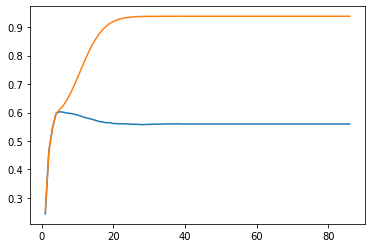

In [28]:
## Plot the scores
plt.plot(scores['Test Score'])
plt.plot(scores['Train Score'])
plt.show()

In [29]:
## Create a version on the scores dataframe
## sorted by highest Test Scores
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
## Display the first (5) rows of the dataframe
sorted_scores.head()

,Test Score,Train Score
5,0.602623,0.610535
6,0.601256,0.624543
7,0.598121,0.643177
8,0.597002,0.666436
4,0.596631,0.595925


In [30]:
## sort the dataframe by test scores and save the index (k) of the best score
best_depth = sorted_scores.index[0]
## Display best_depth
best_depth

5

In [31]:
## Create an instance of the model
ran_for = RandomForestRegressor(max_depth=best_depth, random_state=42)
## Create a model pipeline
ran_for_pipe = make_pipeline(preprocessor, ran_for)
## Fit the model
ran_for_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad483ee0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7dad4837c0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, random_state=42))])

#### Metrics

In [32]:
## Display model performance metrics using a function
model_metrics(ran_for_pipe, x_train=X_train, y_train=y_train, 
                          x_test=X_test, y_test=y_test, 
                           model_name='Tuned Random Forest Model')

Tuned Random Forest Model Train Scores
MAE: 755.3756 
MSE: 1,152,604.3991 
RMSE: 1,073.5942 
R2: 0.6105

Tuned Random Forest Model Test Scores
MAE: 728.3530 
MSE: 1,096,354.0177 
RMSE: 1,047.0693 
R2: 0.6026



## Recommendations

**Model recommended:** Random Forest

- It had the lowest error scores for MAE, MSE and RMSE, and it had the hightest R2 on the Test dataset.

**Random Forest Model Test Scores**
- MAE: 728.3530 
- MSE: 1,096,354.0177 
- RMSE: 1,047.0693 
- R2: 0.6026